In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Adjust depending on notebook location:
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


from src.nlp.partitioner.pipeline import run_nlp_partition_pipeline, load_transcript_json

Project root: C:\Users\chris\OneDrive\Desktop\Segmenta


C:\Users\chris\miniforge3\envs\segmenta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
json_path = PROJECT_ROOT / "transcripts" / "sample.json"
segments = load_transcript_json(json_path)

print("Loaded segments:", len(segments))
segments[:3]

Loaded segments: 539


[{'start': 15.18, 'end': 16.86, 'text': "Right, let's get started."},
 {'start': 16.86,
  'end': 25.18,
  'text': 'So when I covered last week or last session was how to create a CV using'},
 {'start': 25.18, 'end': 26.02, 'text': 'Quarto.'}]

In [3]:
results = run_nlp_partition_pipeline(
    whisper_segments=segments,
    max_duration=60,
    max_gap=2.0,
)

In [4]:
chunks = results["chunks"]
labels = results["labels"]
boundaries = results["boundaries"]
topics = results["topics"]

print("Chunks:", len(chunks))
print("Detected boundaries:", boundaries)
print("Detected topics:", len(topics))

Chunks: 39
Detected boundaries: [0, 9, 14, 18, 21, 28, 31, 34]
Detected topics: 8


In [5]:
print("Raw boundaries:", results["raw_boundaries"])
print("Validated boundaries:", results["boundaries"])
print("Topics:", len(results["topics"]))

Raw boundaries: [0, 1, 3, 9, 10, 14, 16, 18, 20, 21, 22, 23, 28, 29, 30, 31, 32, 33, 34, 38]
Validated boundaries: [0, 9, 14, 18, 21, 28, 31, 34]
Topics: 8


In [6]:
# Print topics
for i, t in enumerate(topics):
    print(f"=== Topic {i+1} ===")
    print(f"Start: {t['start']:.1f}s  End: {t['end']:.1f}s")
    print(t["text"][:300], "...\n")


=== Topic 1 ===
Start: 15.2s  End: 532.6s
Right, let's get started. So when I covered last week or last session was how to create a CV using Quarto. And really the point of that was to just demonstrate the structure of a Quarto document where it involves a gamma header and then just mark down. That's that's really all there is to portotes v ...

=== Topic 2 ===
Start: 532.6s  End: 808.5s
It's going to be a website. And then here, you specify the structure for your website. For example, the title, the nav bar is the navigation bar. If you want to have the navigation bar, you can. So let's get rid of the navigation bar and see what happens. When it click on Save, you'll see that the n ...

=== Topic 3 ===
Start: 808.5s  End: 1043.7s
There you go. And then here, under format, it's going to say the theme that you're using. The default theme is pretty nice. You could change it if you want. But let's just see what kind of themes are out there. So we're told themes. And then here you click on

In [7]:
from src.nlp.partitioner.embedder import Embedder
from src.nlp.partitioner.text_utils import clean_text

embedder = Embedder()
texts = [clean_text(c["text"]) for c in chunks]
embeddings = embedder.encode(texts)

embeddings.shape


(39, 384)

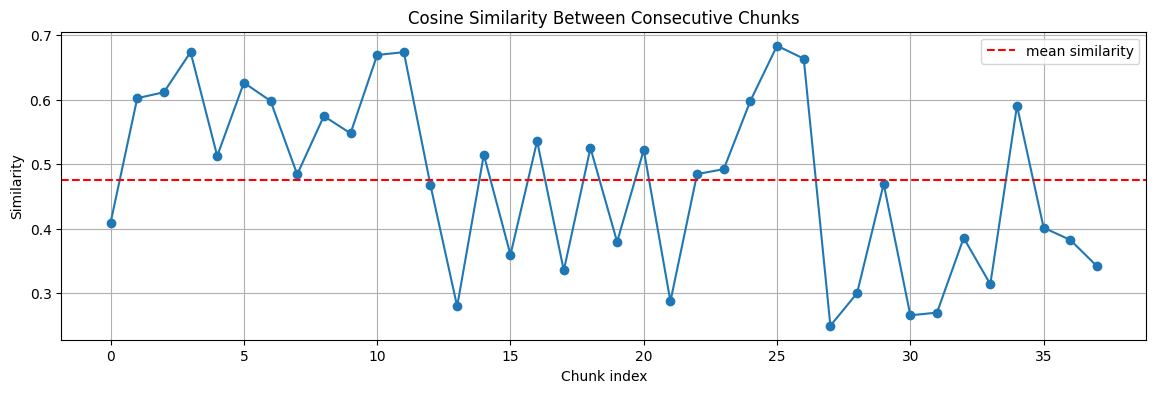

In [8]:
# Normalize
normed = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Pairwise similarities
similarities = [np.dot(normed[i], normed[i-1]) for i in range(1, len(normed))]

plt.figure(figsize=(14,4))
plt.plot(similarities, marker='o')
plt.axhline(y=np.mean(similarities), color='r', linestyle='--', label="mean similarity")
plt.title("Cosine Similarity Between Consecutive Chunks")
plt.xlabel("Chunk index")
plt.ylabel("Similarity")
plt.grid(True)
plt.legend()
plt.show()


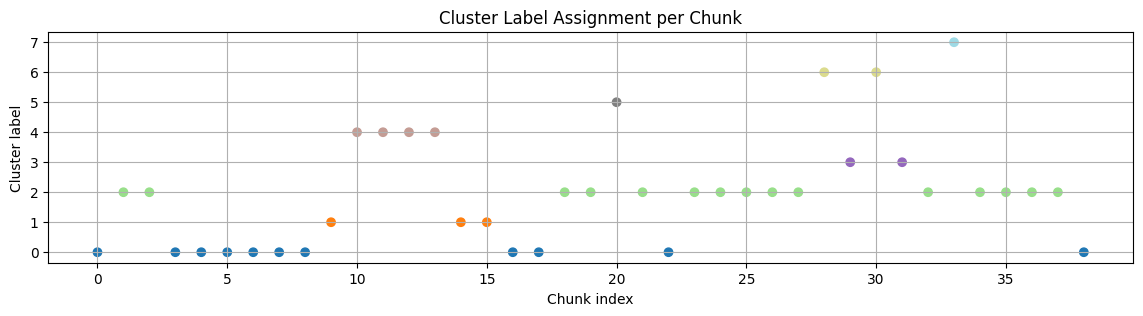

In [9]:
plt.figure(figsize=(14,3))
plt.scatter(range(len(labels)), labels, c=labels, cmap="tab20")
plt.title("Cluster Label Assignment per Chunk")
plt.xlabel("Chunk index")
plt.ylabel("Cluster label")
plt.grid(True)
plt.show()


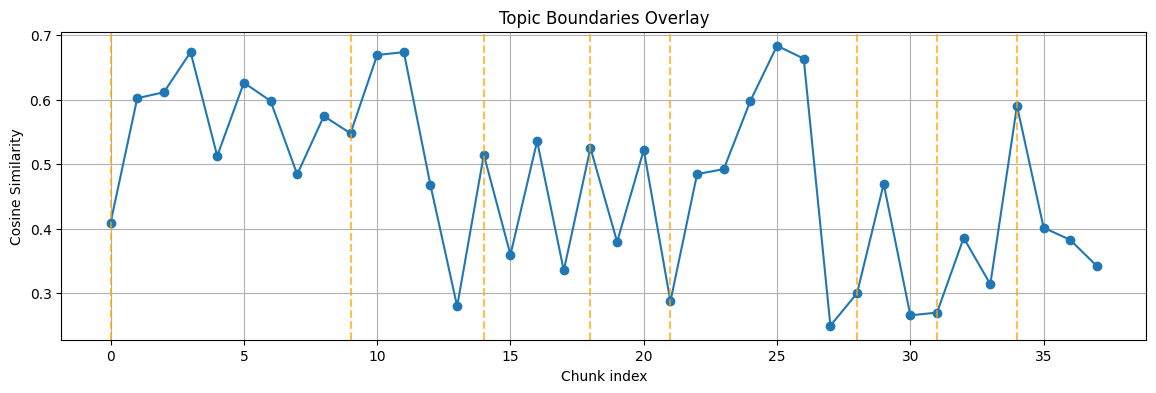

In [10]:
plt.figure(figsize=(14,4))
plt.plot(similarities, label="similarity", marker='o')

for b in boundaries:
    if b < len(similarities):
        plt.axvline(x=b, color='orange', linestyle='--', alpha=0.7)

plt.title("Topic Boundaries Overlay")
plt.xlabel("Chunk index")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()


In [11]:
from datetime import timedelta

def format_ts(seconds):
    """Convert seconds → H:MM:SS format."""
    return str(timedelta(seconds=int(seconds)))


topics = results["topics"]

print(f"\nDetected {len(topics)} topics:\n")

for i, t in enumerate(topics):
    print(f"=== Topic {i+1} ===")
    print(f"Start: {format_ts(t['start'])}   End: {format_ts(t['end'])}")
    print(f"Chunk count: {t['chunk_count']}")
    print(t["text"])
    print("-" * 80)



Detected 8 topics:

=== Topic 1 ===
Start: 0:00:15   End: 0:08:52
Chunk count: 9
Right, let's get started. So when I covered last week or last session was how to create a CV using Quarto. And really the point of that was to just demonstrate the structure of a Quarto document where it involves a gamma header and then just mark down. That's that's really all there is to portotes very similar to our mark down. The only thing that you have to kind of get to know is the yam mold settings here. Or like what can you put according to each document or each document they're going to have different yam mold configurations. But and then how to host this on GitHub. So hopefully you should have this on GitHub. You could do something like it status. And then you can see that everything's up to date in my main folder. And it should be somewhere around here. That's 140xp. Now I can look at all the files that I have not just locally, but on my GitHub repository. It should be private. It could be public